# Feature Scaling 

# Why Do We Need Scaling?

Different features need to be roughly in the same range. 


# Standardization vs. Normalization
Two types depending on its focus: 1) making data more like normal distribution (mean=0, std=1), 2) scaling data to be within fixed range.

There are mixed use of terms but I will stick to 'standardization' for the first category and 'normalization' for the second category. 

Review 4 different types of scalers; 1 for standardization and 3 for normalization.  

| Category |Standardization | Min-max Normalization | Mean Normalization | Median-quantile Nromalization|
|--|--|--|--|--|
| Concepts | Centering + Unit Variance| Fixed Range | Centering + Fixed Range | Centering + Fixed Quantile Range|
| Definition | Convert data to have zero mean and unit variance | Convert data to be within fixed range (e.g. [0, 1]) | Convert data to have zero mean and be within fixed range (e.g. [-1, 1]) | Convert data to have zero median and unit interquantile range |


There are pros and cons in each method. In this post, I would like to walk you through definition and characteristics of each method, as well as how to apply them in Python.



# Scalers Deep Dive

In [4]:
def kdeplot(df, scaler_name):
    fix, ax = plt.subplots(figsize=(7, 5))
    for feature in df.columns:
        sns.kdeplot(df[feature], ax=ax)
    ax.set_title(scaler_name)
    ax.set_ylabel('Density')
    ax.set_xlabel('Feature value')
    plt.tight_layout()
    
def kdeplot_with_zoom(df, scaler_name, xlim):
    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # original  
    for feature in df.columns:
        sns.kdeplot(df[feature], ax=ax1)
    ax1.set_title(scaler_name)
    
    # zoomed 
    for feature in features:
        sns.kdeplot(df[feature], ax=ax2)
    ax2.set_xlim(xlim)
    ax2.set_title(scaler_name + ' (zoomed)')    
    
    plt.tight_layout()

## 0. Original Data

In this analysis, we will use the boston housing-prices dataset available in sklearn library. Among total 13 variables in the dataset, we will focus on 6 variables for easier visualization: 'RM', 'LSTAT', 'CRIM', 'AGE', 'DIS', 'NOX'. As always, we split the data into train and test sets and use the train set for feature engineering to prevent data leakage during testing. 

In [5]:
# import modules 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# load data
boston_dataset = load_boston()
df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

# take only variables we will experiment 
features = ['RM', 'LSTAT', 'CRIM', 'AGE', 'DIS', 'NOX']
df = df[features]
df['MEDV'] = boston_dataset.target # add target 

# split data
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df['MEDV'], 
                                                    test_size=0.3, 
                                                    random_state=0)

When the original distributions of all features are displayed in one plot, we can quickly tell that they are not on the same scale. Some features seem to be clustered in a smaller range, such as 'NOX' or 'RM', and some are spread across a wider range, such as 'LSTAT'. 

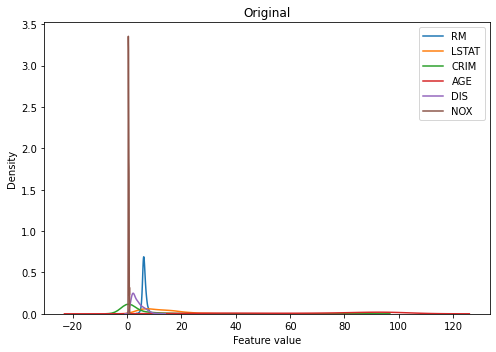

In [6]:
kdeplot(X_train, 'Original')

To quantify the difference in scale between features, we can check some statistic such as mean, standard deviation, minimum, or maximum of observations within each feature. Indeed, they are all very different in their scale and this will be a problem when training certain types of model that requires data to be on the same scale.

In [7]:
X_train.describe().loc[['mean', 'std', 'min', 'max'], :]

,RM,LSTAT,CRIM,AGE,DIS,NOX
mean,6.308427,12.440650,3.358284,68.994068,3.762459,0.556098
std,0.702009,7.078485,8.353223,28.038429,2.067661,0.115601
min,3.561000,1.730000,0.006320,2.900000,1.174200,0.385000
max,8.780000,36.980000,88.976200,100.000000,12.126500,0.871000


## 1. Standardization

The first and most popular option for feature scaling is standardization. 

**Definition**
- Scale data so that the mean becomes 0 and the stadard deviation becomes 1
- The value produced by this process is called Z-score 
$$
Z-score = \frac{X - \mu}{\sigma}
$$
- Z-score represents the position of a value with respect to the mean of the variable

**Characteristics** 
- It centers the variable to 0 and sets the variance to 1 
- It preserves the original distribution
    - If the original distribution was Gaussian, the transformed distribution will also be Gaussian. If it was skewed, the output will be skewed. 
- It preserves outliers

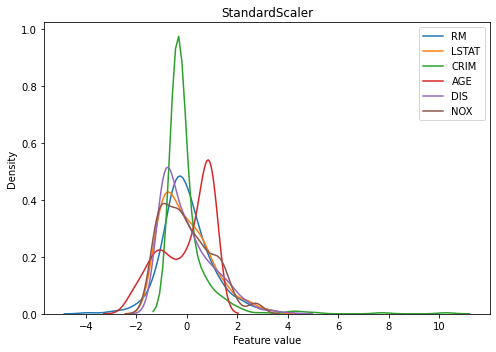

In [8]:
from sklearn.preprocessing import StandardScaler

# fit the scaler to the train set 
scaler_std = StandardScaler().fit(X_train)

# transform data
X_train_scaled_std = scaler_std.transform(X_train)

# put them in dataframe 
X_train_scaled_std = pd.DataFrame(X_train_scaled_std, columns=X_train.columns)

# plot 
kdeplot(X_train_scaled_std, 'StandardScaler')

## 2. Min-max Normalization

### 2.1. MinMaxScaler

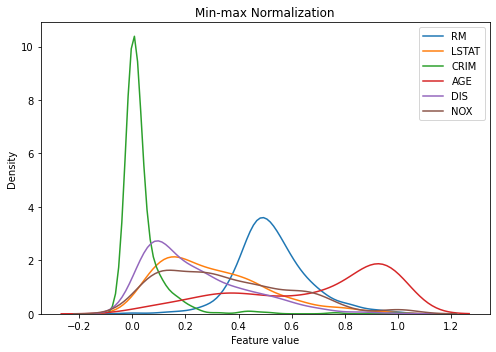

In [10]:
from sklearn.preprocessing import MinMaxScaler

# fit the scaler to the train set 
scaler =MinMaxScaler().fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)

# put them in dataframe 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# all different scale. all starting from 0. (hist plot will show it more clearly)
kdeplot(X_train_scaled, 'Min-max Normalization')

## 2.2. Maximum absolute normalization (MaxAbsScaler)

$$X_{scaled} = \frac{X}{max(X)}$$

In [20]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
kdeplot(X_train_scaled, 'Maximum Absolute Scaler')


# centering + MaxAbsScaling: center distribution at zero and then scale to its absolute maximum. recommended by sklearn
scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_maxabs = MaxAbsScaler()

scaler_mean.fit(X_train)
scaler_maxabs.fit(X_train)

X_train_scaled = pd.DataFrame(scaler_maxabs.transform(scaler_mean.transform(X_train)), columns=X_train.columns)
kdeplot(X_train_scaled, 'Maximum Absolute Scaler')

## 3. Mean Normalization

In [12]:
from sklearn.preprocessing import RobustScaler

# Set up the StandardScaler so that it removes the mean 
# but does not divide by the standard deviation
scaler_mean = StandardScaler(with_mean=True, with_std=False)

# Set up the RobustScaler so that it does NOT remove the median 
# but normalize by max()-min(). Important to set up the quantile range
# to 0 to 100, which represents the min and max values
scaler_minmax = RobustScaler(with_centering=False,
                            with_scaling=True,
                            quantile_range=(0, 100))

# fit the scaler to the train set 
scaler_mean.fit(X_train)
scaler_minmax.fit(X_train)

# transform train and test sets
X_train_scaled = scaler_minmax.transform(scaler_mean.transform(X_train))

# put them in dataframe 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

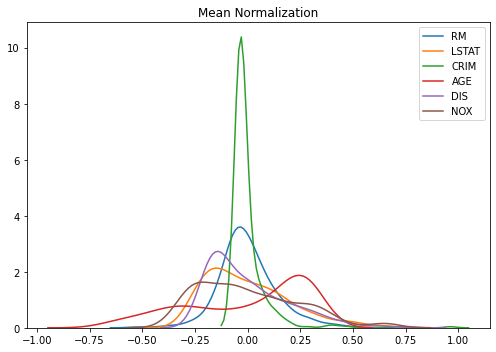

In [15]:
# all from -1 to 0
kdeplot(X_train_scaled, 'Mean Normalization')

## 4. Median and quantile scaling (RobustScaler)

$$ X_{scaled} = \frac{X-median(X)}{75th quantile(X) - 25th quantile(X)}$$ 

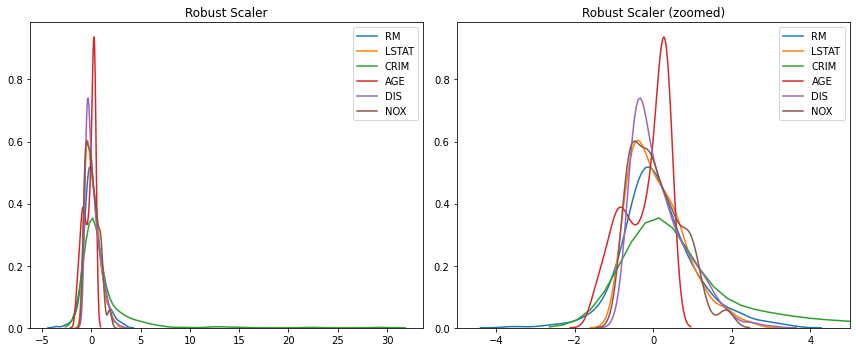

In [50]:
from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)


kdeplot_with_zoom(X_train_scaled, 'Robust Scaler', [-5, 5])

# kdeplot(X_train_scaled, 'Robust Scaler')
# plt.show()
# kdeplot(X_train_scaled, 'Robust Scaler')
# plt.xlim([-5, 5])
# plt.show()

## Compare

In [ ]:
rows, cols = 4, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 15))

i=0
for name, df in [('Original', X_train), 
                 ('Standardization', X_train_std), 
                 ('Min-max scaler', X_train_mm), 
                 ('Mean normalization (centering + Min-max scaler)', X_train_mean),
                 ('Max-abs scaler', X_train_ma1), 
                 ('Centering + Max-abs scaler', X_train_ma), 
                 ('Robus scaler', X_train_rbs)]:
    row, col = i//cols, i%cols
    ax = axes[row, col]
    for var in features:
        sns.kdeplot(df[var], ax=ax)
    ax.set_title(name)
    i += 1

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
for var in features:
    sns.kdeplot(X_train_rbs[var], ax=ax)
ax.set_title(name)
ax.set_xlim([-5,5])
plt.show()

In [ ]:
X_train_rbs.describe()

# Summary 

| Category |Standardization | Min-max Normalization | Mean Normalization | Median-quantile Nromalization|
|--|--|--|--|--|
| Concepts | Centering + Unit Variance| Fixed Range | Centering + Fixed Range | Centering + Fixed Quantile Range|
| Definition | Convert data to have zero mean and unit variance | Convert data to be within fixed range (e.g. [0, 1]) | Convert data to have zero mean and be within fixed range (e.g. [-1, 1]) | Convert data to have zero median and unit interquantile range |
|Sklearn classes| StandardScaler| MinMaxScaler/<br>MaxAbsScaler | StandardScaler + RobustScaler<br><br>* *StandardScaler only for mean removal*<br> * *RobustScaler only for scaling with 0, 100 quantile* | RobustScaler|
| Benefits | - Less sensitive to outliers <br>- Easier to compare and learn <br>- Preserves original distribution | - Features in the same range | - Features in the same range| - Least sensitive to outliers <br>- Better spread of values for skewed distribution |
| Limitations |- Range varies between variables <br>- Preserves outliers | - Sensitive to outliers <br>- Mean and variance vary between features | - Sensitive to outliers <br>-Variance varies between features | - Range varies between features <br>-Variance varies between features |

* General guideline: 1) Does the algorithm prefer data to be centered at 0? 2) Does the algorithm prefer data to be in fixed range?
* It is recommended to handle outliers beforehand

# References

# Appendix
## Scaling to vector unit length

Divide each feature vector by either Manhattan distance or Euclidean distance 
* Manhattan distance (L1 norm)
  $$L1(X) = |X_1| + |X_2| + ... + |X_n| $$
* Euclidean distance (L2 norm)
  $$L2(X) = \sqrt{X_1^2 + X_2^2 + ... + X_n^2} $$

In [ ]:
from sklearn.preprocessing import Normalizer

# Manhattan distance
scaler = Normalizer(norm='l1')  # or l2
scaler.fit(X_train) # this does nothing
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns) # actual transform
plot(X_train, X_train_scaled)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(X_train['RM'], ax=ax[0])
sns.kdeplot(X_train_scaled['RM'], ax=ax[1])

In [ ]:
# Manhattan distance
scaler = Normalizer(norm='l2')  # or l2
scaler.fit(X_train) # this does nothing
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns) # actual transform
plot(X_train, X_train_scaled)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(X_train['RM'], ax=ax[0])
sns.kdeplot(X_train_scaled['RM'], ax=ax[1])

In [24]:
# # outlier clipping
# df_capped = df.copy()
# for var in df.columns:
#     x = df[var]
#     iqr = x.quantile(0.75) - x.quantile(0.25)
#     upper = x.quantile(0.75) + iqr*3
#     lower = x.quantile(0.25) - iqr*3
    
#     df_capped[var] = np.where(x > upper, upper, np.where(x < lower, lower, x))
#     x2 = df_capped[var]
#     print(f"{var}, before capping: {len(x[(x > upper) | (x < lower)])}, after capping: {len(x2[(x2 > upper) | (x2 < lower)])}")